In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import ipaddress
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


train_dataset_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
test_dataset_path = 'dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)

def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y
# 위의 과정을 통해 Flow ID라는 int 형태가 될 수 없는 데이터와
# y로 분리되어 있는 Label을 제외한 나머지 데이터는 모두 숫자형으로 변환된다.

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)



In [5]:
top6_features_path = open('models/top6_features.txt', 'r')
top6_features = [line.strip() for line in top6_features_path.readlines()]
top6_features_path.close()
print("## Top 6 Features:")
for feature in top6_features:
    print(f" - {feature}")

best_features_path = open('models/best_features.txt', 'r')
best_features = [line.strip() for line in best_features_path.readlines()]
best_features_path.close()
print(f"## Best Features (Top {len(best_features)}):")
for feature in best_features:
    print(f" - {feature}")

X_train_top6 = X_train[top6_features]
X_test_top6 = X_test[top6_features]

X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

## Top 6 Features:
 - Source_IP
 - Timestamp
 - Avg_Bwd_Segment_Size
 - Bwd_Packet_Length_Mean
 - Bwd_Packet_Length_Std
 - Destination_Port
## Best Features (Top 67):
 - Source_IP
 - Source_Port
 - Destination_IP
 - Destination_Port
 - Protocol
 - Timestamp
 - Flow_Duration
 - Total_Fwd_Packets
 - Total_Backward_Packets
 - Total_Length_of_Fwd_Packets
 - Total_Length_of_Bwd_Packets
 - Fwd_Packet_Length_Max
 - Fwd_Packet_Length_Min
 - Fwd_Packet_Length_Mean
 - Fwd_Packet_Length_Std
 - Bwd_Packet_Length_Max
 - Bwd_Packet_Length_Min
 - Bwd_Packet_Length_Mean
 - Bwd_Packet_Length_Std
 - Flow_Bytes_s
 - Flow_Packets_s
 - Flow_IAT_Mean
 - Flow_IAT_Std
 - Flow_IAT_Max
 - Flow_IAT_Min
 - Fwd_IAT_Total
 - Fwd_IAT_Mean
 - Fwd_IAT_Std
 - Fwd_IAT_Max
 - Fwd_IAT_Min
 - Bwd_IAT_Mean
 - Bwd_IAT_Std
 - Bwd_IAT_Max
 - Bwd_IAT_Min
 - Fwd_Header_Length
 - Bwd_Header_Length
 - Fwd_Packets_s
 - Bwd_Packets_s
 - Min_Packet_Length
 - Max_Packet_Length
 - Packet_Length_Mean
 - Packet_Length_Std
 - Packet_Lengt

In [6]:
print("## 모델 불러오기")

import joblib
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import h5py

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

rf_full_path = os.path.abspath('models/rf_model_full.pkl')
rf_top6_path = os.path.abspath('models/rf_model_top6.pkl')
rf_best_path = os.path.abspath('models/rf_model_best.pkl')
lstm_path = os.path.abspath('models/lstm_model.h5')

rf_full_model = joblib.load(rf_full_path)
rf_top6_model = joblib.load(rf_top6_path)
rf_best_model = joblib.load(rf_best_path)

# with h5py.File(lstm_path, 'r') as f:
lstm_model = load_model(lstm_path)

## 모델 불러오기


7055/7055 [==============================] - 6s 842us/step


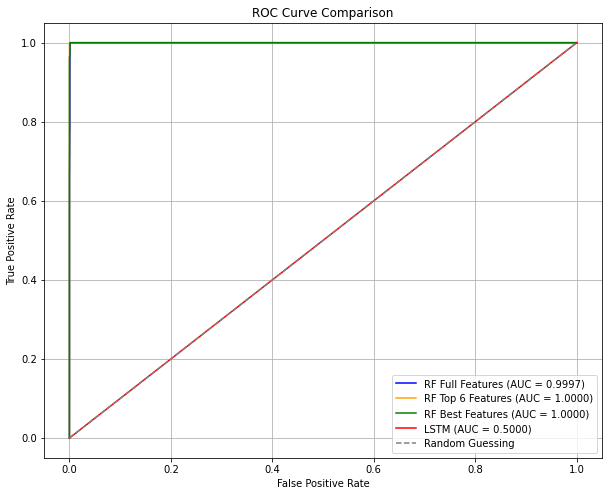

In [7]:
## ROC 곡선 시각화
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_rf_full = rf_full_model.predict_proba(X_test)[:, 1]
y_pred_rf_top6 = rf_top6_model.predict_proba(X_test_top6)[:, 1]
y_pred_rf_best = rf_best_model.predict_proba(X_test_best)[:, 1]
y_pred_lstm = lstm_model.predict(X_test_lstm).ravel()

fpr_rf_full, tpr_rf_full, _ = roc_curve(y_test, y_pred_rf_full)
fpr_rf_top6, tpr_rf_top6, _ = roc_curve(y_test, y_pred_rf_top6)
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_test, y_pred_rf_best)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)

roc_auc_rf_full = auc(fpr_rf_full, tpr_rf_full)
roc_auc_rf_top6 = auc(fpr_rf_top6, tpr_rf_top6)
roc_auc_rf_best = auc(fpr_rf_best, tpr_rf_best)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf_full, tpr_rf_full, color='blue', label=f'RF Full Features (AUC = {roc_auc_rf_full:.4f})')
plt.plot(fpr_rf_top6, tpr_rf_top6, color='orange', label=f'RF Top 6 Features (AUC = {roc_auc_rf_top6:.4f})')
plt.plot(fpr_rf_best, tpr_rf_best, color='green', label=f'RF Best Features (AUC = {roc_auc_rf_best:.4f})')
plt.plot(fpr_lstm, tpr_lstm, color='red', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.savefig('roc_curve_comparison.png')

plt.show()